In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error

from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold


## Shifting and rescaling data

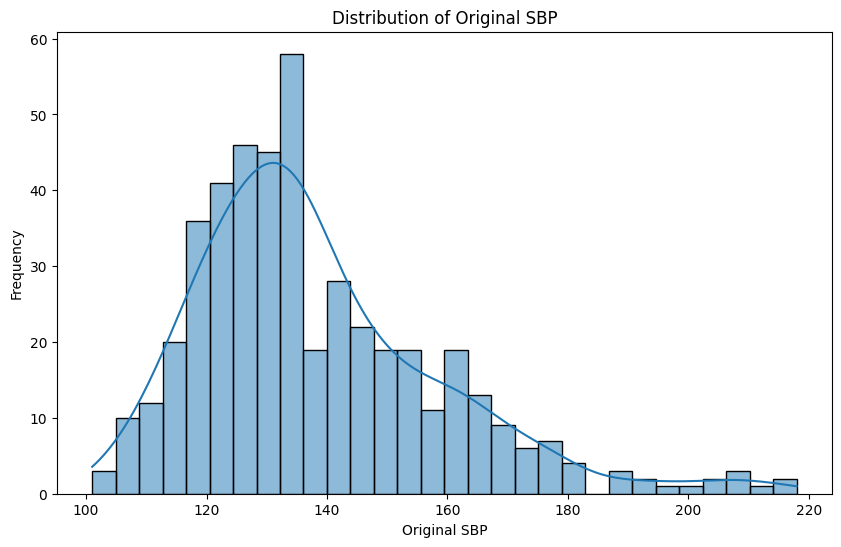

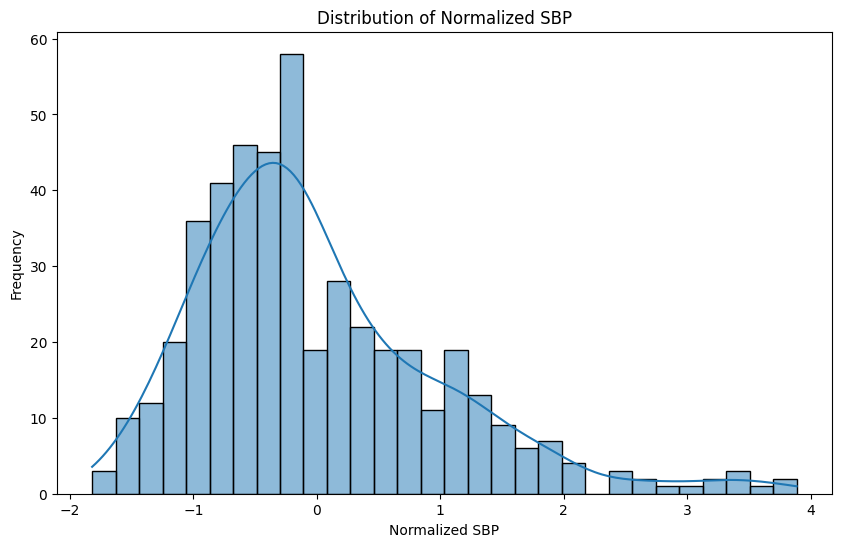

In [3]:
#receives a csv and returns a regularized dataframe
"""def regularize_data(file):
    df = pd.read_csv(file)
    df_copy = df.copy()
    continuous_features = ['sbp', 'tobacco', 'ldl', 'adiposity','typea', 'obesity', 'alcohol', 'age']

    for feat in continuous_features:
        #shifts the values to have mean 0 and std 1
        df_copy[feat] = (df[feat] - df[feat].mean()) / df[feat].std()

    #normalize non continuous features
    df_copy['famhist'] = df_copy['famhist'].map({'Present': 1, 'Absent': 0})

    return df_copy
"""
def regularize_data(file):
    df = pd.read_csv(file)
    df['famhist'] = df['famhist'].map({'Present': 1, 'Absent': 0})
    df = (df-df.mean()) / df.std()
    return df

normalized_df = regularize_data('data.csv')

#plot sbp before and after normalization side by side
plt.figure(figsize=(10, 6))
df = pd.read_csv('data.csv')
sns.histplot(df['sbp'], bins=30, kde=True)
plt.title('Distribution of Original SBP')
plt.xlabel('Original SBP')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(normalized_df['sbp'], bins=30, kde=True)
plt.title('Distribution of Normalized SBP')
plt.xlabel('Normalized SBP')
plt.ylabel('Frequency')
plt.show()



# Linear Regression Baseline


In [ ]:
from sklearn.metrics import mean_absolute_error

df = regularize_data("data.csv")
target = 'adiposity'

drop_cols = ["row.names"]
X = df.drop(columns=[target] + drop_cols)
y = df[target]
X_np = np.asarray(X)
y_np = np.asarray(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline model: always predict mean of training target
y_pred = np.full_like(y_test, fill_value=np.mean(y_train), dtype=float)

mae = mean_absolute_error(y_test, y_pred)
print(f"Baseline MAE (mean predictor): {mae:.4f}")


Baseline MAE (mean predictor): 0.9217


# Best Neural Network

In [ ]:
def build_ann(n_features_in_ = X_np.shape[1], h=32, l2_lambda=0.1):
    model = Sequential([
        Dense(h, activation="relu",
              input_shape=(n_features_in_,),
              kernel_regularizer=regularizers.l2(l2_lambda)),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mse"])
    return model

early = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

reg = KerasRegressor(
    model=build_ann,
    model__n_features_in_=X_np.shape[1],
    epochs=300,
    batch_size=32,
    verbose=0,
    validation_split=0.2,                  # only for early stopping signal
    fit__callbacks=[early],
)

param_grid = {
    "model__h":        [1, 2, 4, 8, 16, 32],
    "model__l2_lambda":[0.0, 1e-4, 1e-3, 1e-2, 1e-1],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

gs.fit(X_np, y_np)

print("Best params:", gs.best_params_)
print("Best CV mse:", -gs.best_score_)

# 2 level cross validation

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Two-level CV setup
K1, K2 = 10, 10
outer_kf = KFold(n_splits=K1, shuffle=True, random_state=42)
inner_kf = KFold(n_splits=K2, shuffle=True, random_state=1)

# Baseline model (predicts mean of y)
baseline = DummyRegressor(strategy="mean")

outer_mse_ann = []
outer_mse_baseline = []
best_params = []

for outer_i, (train_idx, test_idx) in enumerate(outer_kf.split(X_np, y_np), start=1):
    X_train, X_test = X_np[train_idx], X_np[test_idx]
    y_train, y_test = y_np[train_idx], y_np[test_idx]
    
    # INNER LOOP: grid search for ANN hyperparameters
    gs = GridSearchCV(
        estimator=reg,
        param_grid=param_grid,
        cv=inner_kf,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
        refit=True
    )
    gs.fit(X_train, y_train)
    best_params.append(gs.best_params_)
    
    # Evaluate best ANN on outer test set
    best_ann = gs.best_estimator_
    y_pred_ann = best_ann.predict(X_test)
    mse_ann = mean_squared_error(y_test, y_pred_ann)
    outer_mse_ann.append(mse_ann)
    
    # Baseline (mean predictor)
    baseline.fit(X_train, y_train)
    y_pred_base = baseline.predict(X_test)
    mse_base = mean_squared_error(y_test, y_pred_base)
    outer_mse_baseline.append(mse_base)

    print(f"Fold {outer_i}: ANN MSE={mse_ann:.4f}, Baseline MSE={mse_base:.4f}, Best params={gs.best_params_}")

# Summary
print("\n===== SUMMARY =====")
print("Mean ANN MSE:", np.mean(outer_mse_ann).round(4), "±", np.std(outer_mse_ann).round(4))
print("Mean Baseline MSE:", np.mean(outer_mse_baseline).round(4), "±", np.std(outer_mse_baseline).round(4))


c:\Users\User\anaconda3\envs\dtu\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1: ANN MSE=0.3143, Baseline MSE=1.3028, Best params={'model__h': 8, 'model__l2_lambda': 0.1}


c:\Users\User\anaconda3\envs\dtu\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 2: ANN MSE=0.2803, Baseline MSE=1.0992, Best params={'model__h': 16, 'model__l2_lambda': 0.1}


c:\Users\User\anaconda3\envs\dtu\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 3: ANN MSE=0.2169, Baseline MSE=0.8503, Best params={'model__h': 16, 'model__l2_lambda': 0.1}


c:\Users\User\anaconda3\envs\dtu\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 4: ANN MSE=0.1919, Baseline MSE=0.9732, Best params={'model__h': 16, 'model__l2_lambda': 0.1}


c:\Users\User\anaconda3\envs\dtu\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 5: ANN MSE=0.2802, Baseline MSE=0.9974, Best params={'model__h': 32, 'model__l2_lambda': 0.1}


c:\Users\User\anaconda3\envs\dtu\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\User\anaconda3\envs\dtu\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 6: ANN MSE=0.2021, Baseline MSE=1.2642, Best params={'model__h': 32, 'model__l2_lambda': 0.1}


c:\Users\User\anaconda3\envs\dtu\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\User\anaconda3\envs\dtu\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 7: ANN MSE=0.4909, Baseline MSE=1.0754, Best params={'model__h': 32, 'model__l2_lambda': 0.1}


c:\Users\User\anaconda3\envs\dtu\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 8: ANN MSE=0.1837, Baseline MSE=0.9835, Best params={'model__h': 32, 'model__l2_lambda': 0.1}


c:\Users\User\anaconda3\envs\dtu\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 9: ANN MSE=0.2522, Baseline MSE=0.6456, Best params={'model__h': 16, 'model__l2_lambda': 0.1}


c:\Users\User\anaconda3\envs\dtu\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 10: ANN MSE=0.3467, Baseline MSE=0.8160, Best params={'model__h': 32, 'model__l2_lambda': 0.1}

===== SUMMARY =====
Mean ANN MSE: 0.2759 ± 0.0882
Mean Baseline MSE: 1.0008 ± 0.1897
